In [1]:
import pandas as pd
import numpy as np
import sympy as sp
import sympy
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('path/to/ShotReceData.csv')


a = sp.Symbol('a')
#定义sigma
sigma = 2
#定义h
h = 40
#定义size
size = 100
#定义右端f_k


#创建等号左端三对角
def create_tridiagonal_matrix(size):
    matrix = sp.zeros(size, size)

    for i in range(size):
        if i == 0:
            matrix[i, i] = 1
        elif i == size - 1:
            matrix[i, i] = 1
        else:
            matrix[i, i] = 2
            matrix[i, i-1] = 0.5
            matrix[i, i+1] = 0.5

    return matrix

tri_mat1 = create_tridiagonal_matrix(size)

#创建等号右端三对角
def create_tridiagonal_matrix(size):
    matrix = sp.zeros(size, size)

    for i in range(size):
        if i in range(1 ,size-1 ):
            matrix[i, i] = -2
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1

    return matrix

tri_mat2 = create_tridiagonal_matrix(size)

#定义等号右端五对角
def create_fivediagonal_matrix(size , a):
    matrix = sympy.zeros(size, size)

    for i in range(size):
        if i == 1:
            matrix[i, i-1] = a-2
            matrix[i, i] = 5-a
            matrix[i, i+1] = -4
            matrix[i, i+2] = 1
        elif i == size-2:
            matrix[i, i-2] = 1
            matrix[i, i-1] = -4
            matrix[i, i] = 5-a
            matrix[i, i+1] = a-2
        elif i in range(2 ,size-2 ) :
            matrix[i, i-2] = -1
            matrix[i, i-1] = 4
            matrix[i, i] = -6
            matrix[i, i+1] = 4
            matrix[i, i+2] = -1

    return matrix

five_mat = create_fivediagonal_matrix(size , a)

#函数：找到每个炮点的所有检波点的FT，第i列为从100i0001到100i0100的检波点处的FT
def create_matrix_for_shotnum(shot_num):
    group_df = df[df['ShotNum'] == shot_num]
    matrix_data = []
    for i in range(1, 21):
        sub_group_df = group_df[(group_df['ReceNum'].between((1000+i)*10000+1, (1000+i)*10000+100))] 
        matrix_data.append(sub_group_df['First Time'].tolist())

    matrix_df = pd.DataFrame(matrix_data).transpose()
    return matrix_df

#定义每个炮点对应的FT矩阵F_shotnum(100*20)
for shot_num in df['ShotNum'].unique():
    matrix_for_shotnum = create_matrix_for_shotnum(shot_num)
    globals()['F%s' % shot_num] = matrix_for_shotnum

#定义每个炮点的残差初始空矩阵
for shot_num in df['ShotNum'].unique()[:2]:
    globals()['E%s' % shot_num] = np.zeros((size, 20))


N = 10
a_values = 10**np.linspace(-8, -6, N)
n = size - 1
Delta = []

for shot_num in df['ShotNum'].unique()[:2]:
    F_matrix = globals()['F%s' % shot_num]
    E_shot_num = globals()['E%s' % shot_num]

    for i in range(0, 20):
        s_values = []
        e_values = np.zeros((size, N))  
        
        for a in a_values:
            five_mat = create_fivediagonal_matrix(size, a)
            f=sp.Matrix(F_matrix.iloc[:, i].to_numpy())
            A = tri_mat1 - (3 * sigma ** 2)/(a * h ** 3) * five_mat
            b = (3 / h ** 2) * tri_mat2 * f
            M = A.solve(b)
            Y = sp.zeros(size, 1) 
            Y[0] = (sigma**2 / h) * (M[0] - M[1]) + F_matrix.iloc[0,i]
            Y[n] = (sigma**2 / h) * (M[n] - M[n-1]) + F_matrix.iloc[n,i]
            for k in range(1, n):
                Y[k] = sigma**2 / (a * h) * (-M[k-1] + 2*M[k] - M[k+1]) + F_matrix.iloc[k,i]  

            e = Y - f
            e_values[:,np.where(a_values == a)[0]]=np.array(e)[:, 0][:, np.newaxis] 

            s = (e.T * e)[0] / sigma**2
            s_values.append(s)  

        min_index = np.argmin(np.abs(np.array(s_values) - 100))
        E_shot_num[:, i] = e_values[:,min_index]
    
    delta_shut_num = round(np.sum(E_shot_num)/2, 6) #保留六位小数
    Delta.append(delta_shut_num)

In [2]:
Delta

[7.84289, 7.804038]

In [3]:
# 创建DataFrame
data = {'shotnum': df['ShotNum'].unique()[:2], 'Delta': Delta}
df_combined = pd.DataFrame(data)

# 保存为CSV文件
df_combined.to_csv('path/to/Delta2.csv', index=False)

In [21]:
Delta_df = pd.read_csv('path/to/Delta2.csv')
G_shot_num = np.zeros((100,20))
for shot_num in df['ShotNum'].unique()[:2]:
    E_shot_num = globals()['E%s' % shot_num]
    G_add = E_shot_num - Delta_df[Delta_df['shotnum'] == shot_num]['Delta'].values[0] 
    G_shot_num += G_add / 2

In [22]:
#拉直接收点扰动
G_shot_num_flat = G_shot_num.T.flatten()
pd.DataFrame({'G': G_shot_num_flat}).to_csv('path/to/G.csv', index=False)

In [23]:
#得到每各接收点的坐标
Rece_x = np.concatenate(df.groupby('ReceNum')['Recex'].unique().reset_index()['Recex'])
Rece_y = np.concatenate(df.groupby('ReceNum')['Recey'].unique().reset_index()['Recey'])

#得到每各炮点的坐标
Shot_x = np.concatenate(df.groupby('ShotNum')['Shotx'].unique().reset_index()['Shotx'])
Shot_y = np.concatenate(df.groupby('ShotNum')['Shoty'].unique().reset_index()['Shoty'])

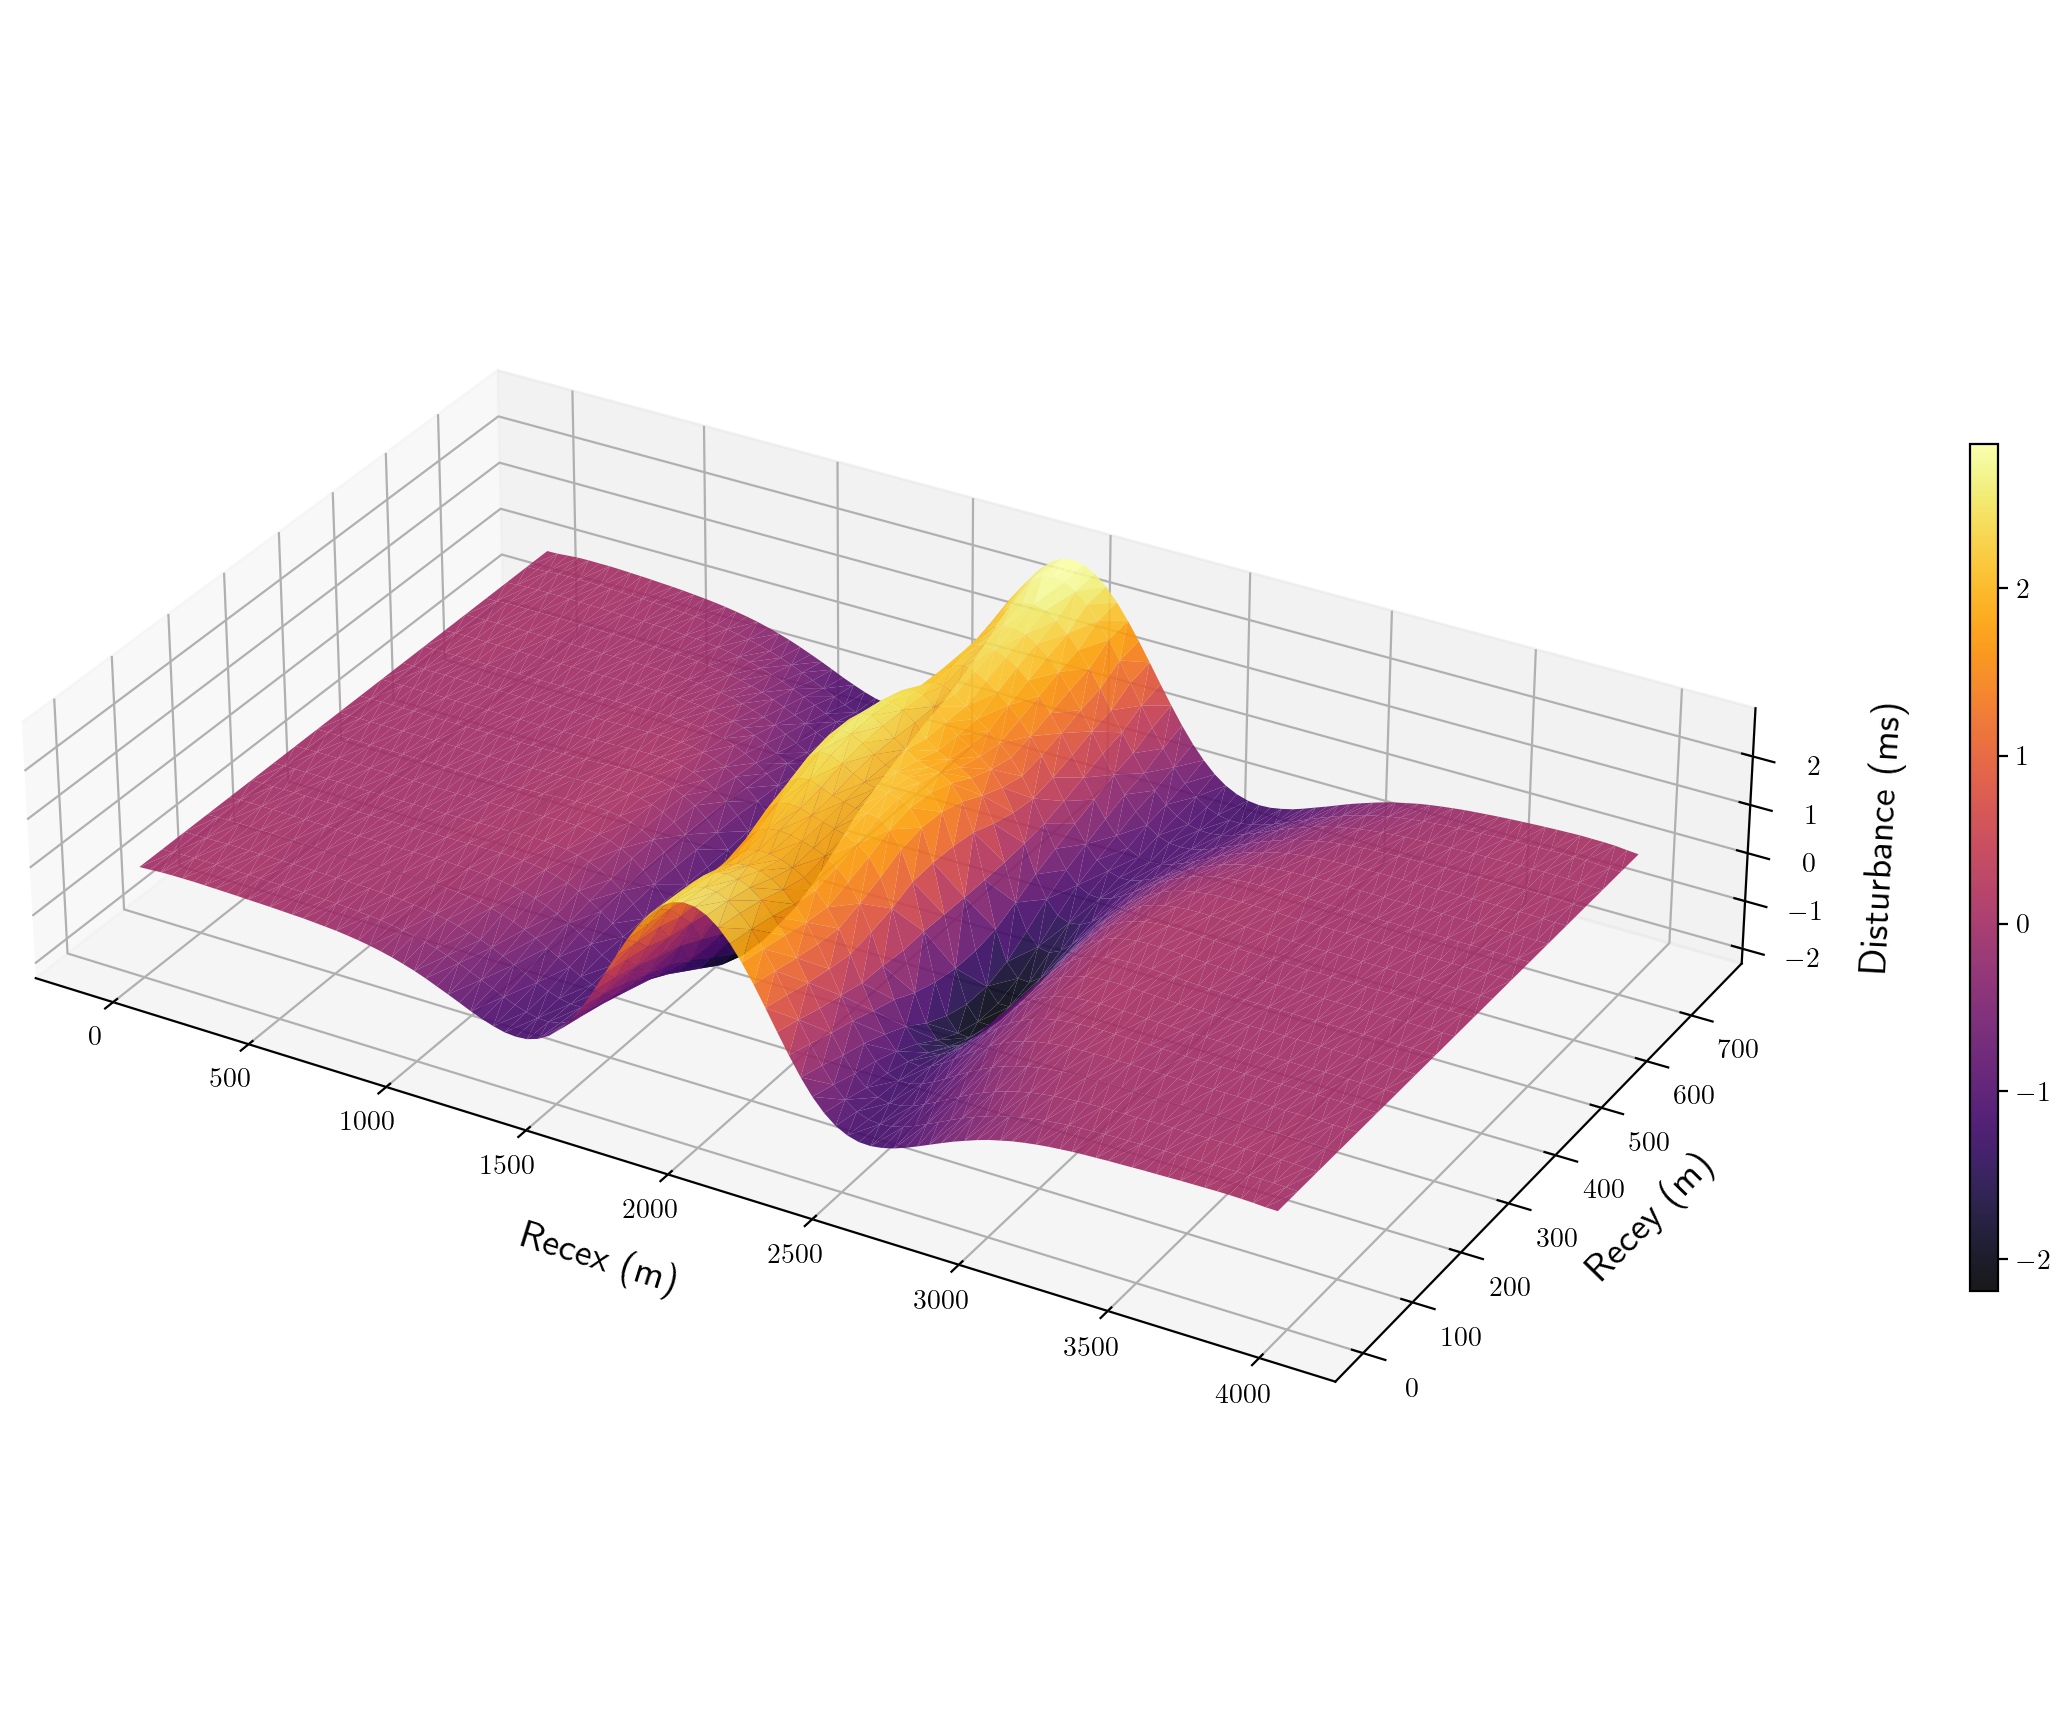

In [103]:
#绘制接收点扰动三维图
plt.rcParams.update({'text.usetex': True})
fig = plt.figure(figsize=(33, 11))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Rece_x, Rece_y, G_shot_num_flat, cmap='inferno', linewidth=0.2, alpha=0.9)
cbar = fig.colorbar(surf, shrink=0.5, aspect=30) 

ax.set_xlabel(r'Recex (m)', fontsize=14,labelpad=20)
ax.set_ylabel(r'Recey (m)', fontsize=14)
ax.set_zlabel(r'Disturbance (ms)', fontsize=14)

ax.set_box_aspect([5,3,1])  # 设置x轴和y轴的比例为1:1，z轴比例为0.5

# plt.title('Disturbance of Receiver',fontsize = 20)
plt.show()

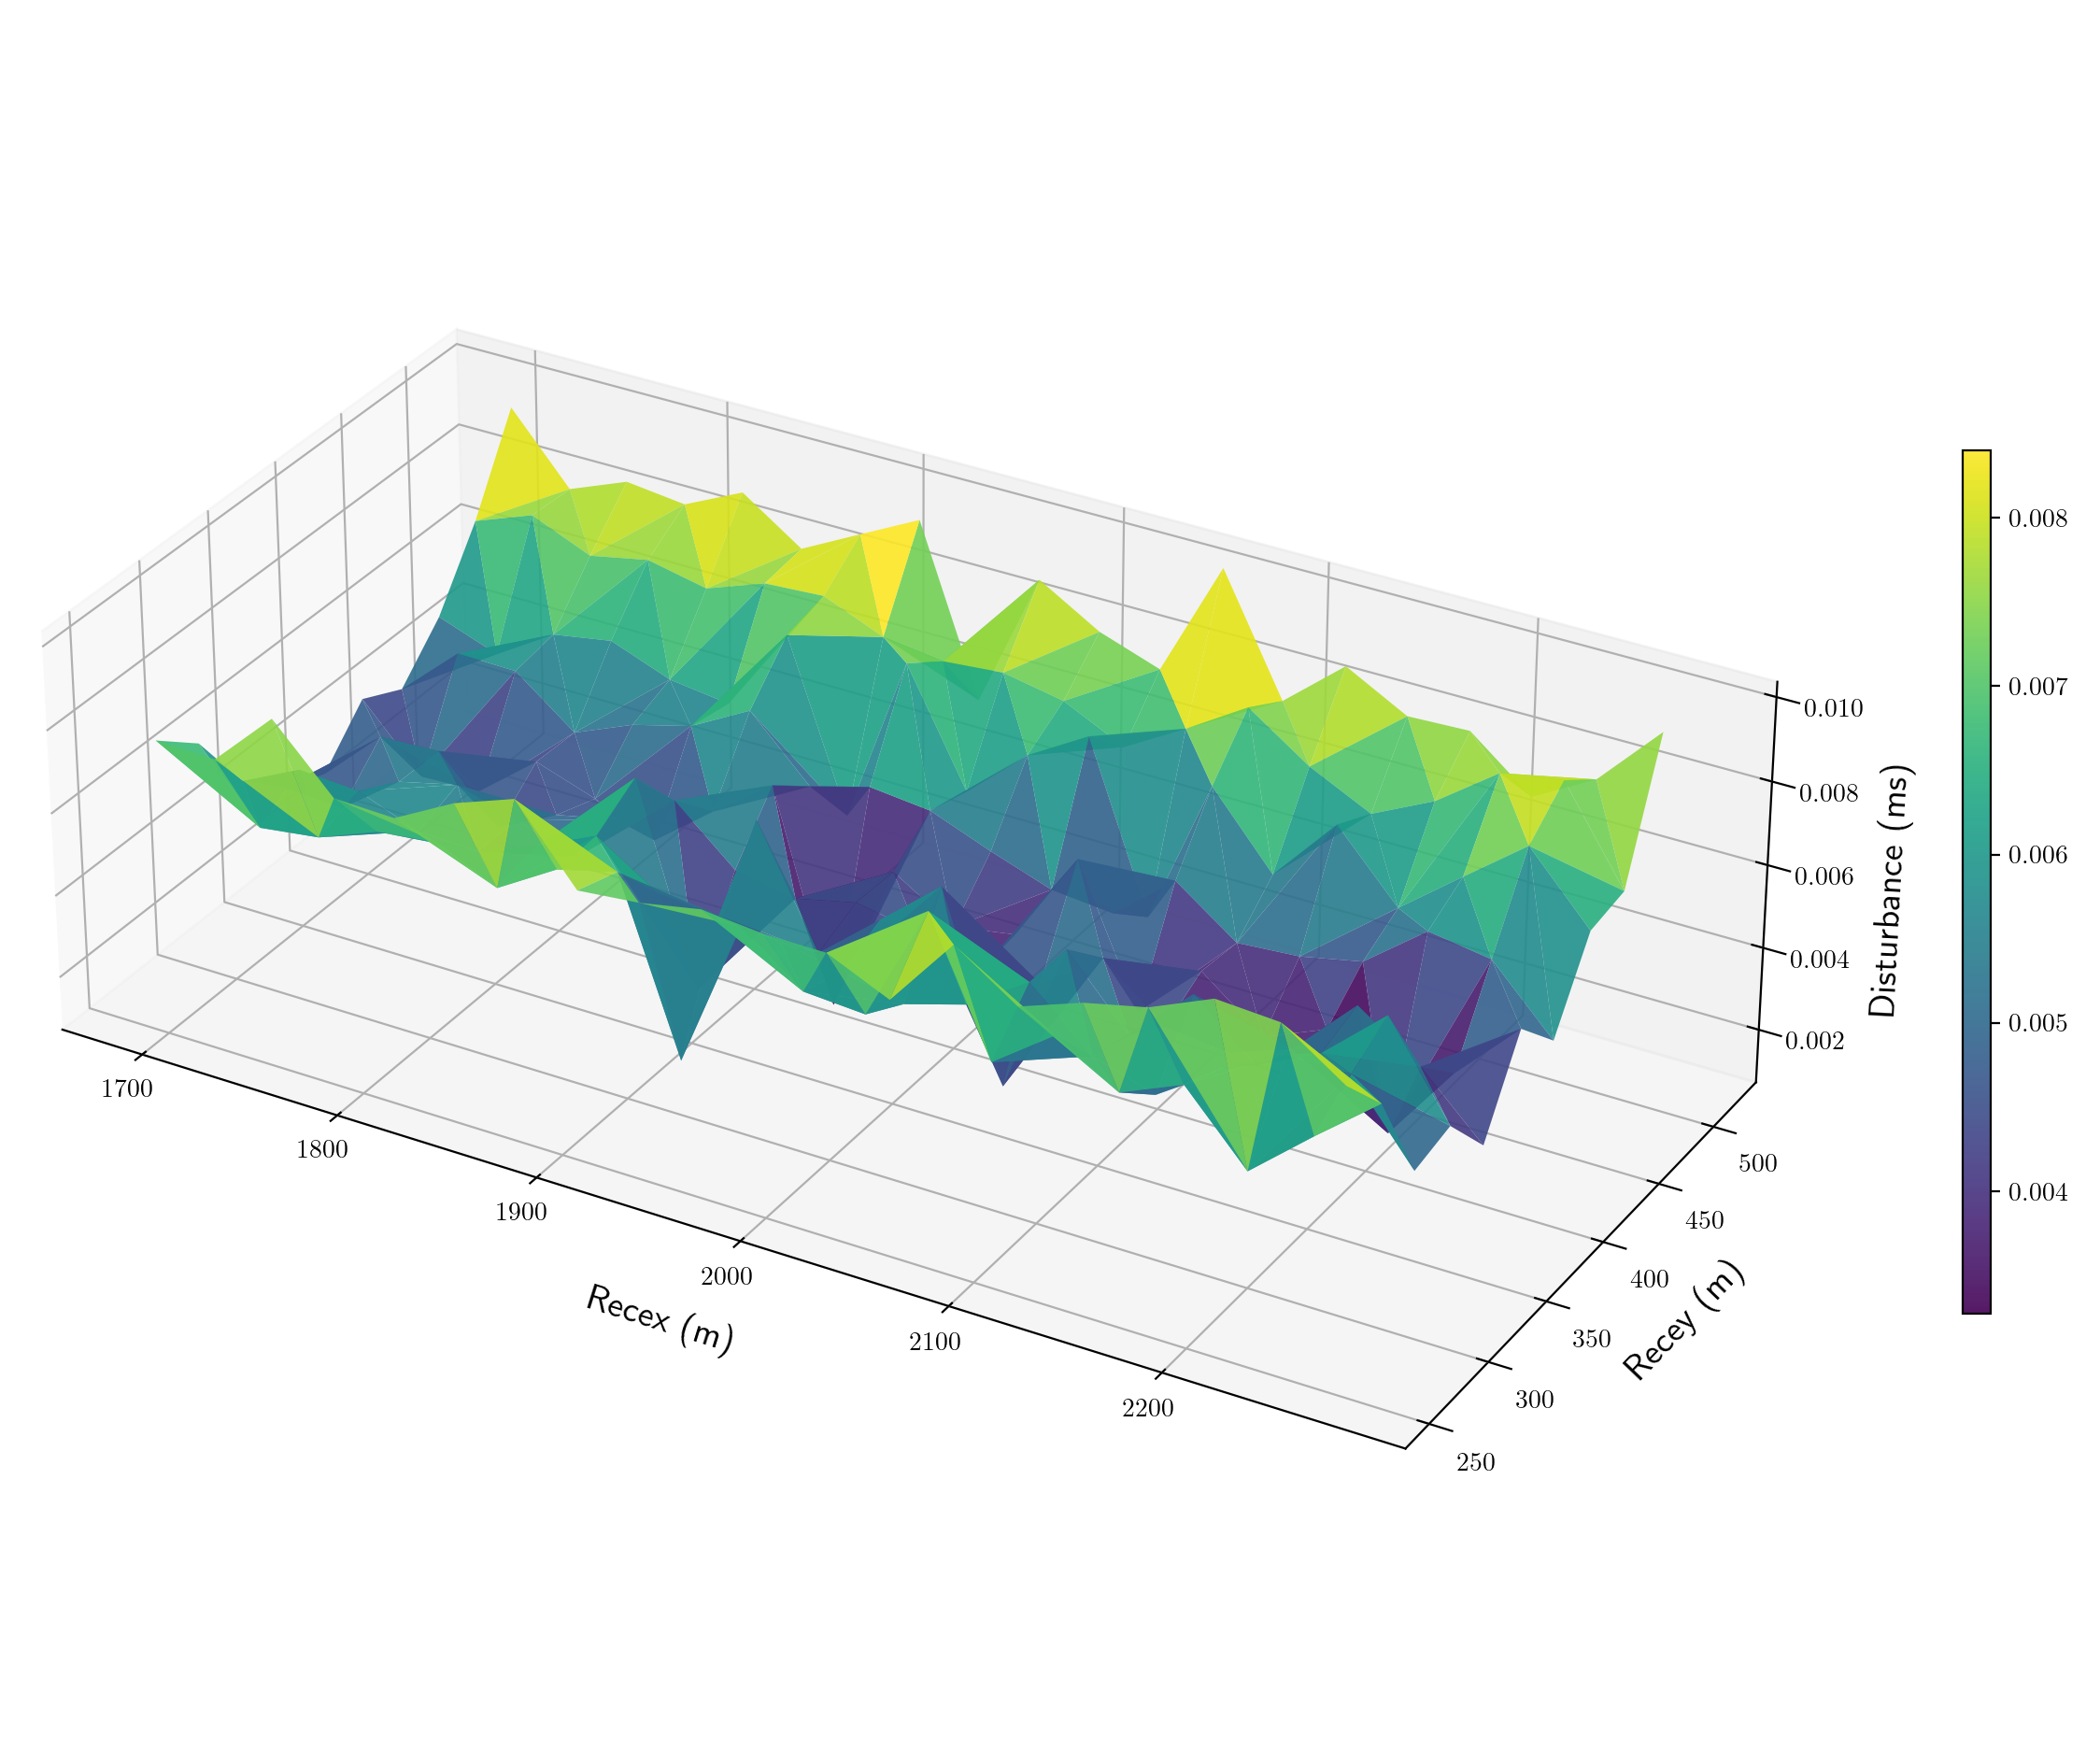

In [104]:
#绘制炮点扰动三维图
Deltadf = pd.read_csv('path/to/Delta200.csv')
Delta200 = Deltadf['Delta']
plt.rcParams.update({'text.usetex': True})
fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Shot_x, Shot_y, Delta200 * 10 ** (-3) , cmap='viridis', linewidth=0.2, alpha=0.9)
cbar = fig.colorbar(surf, shrink=0.5, aspect=30) 

ax.set_xlabel(r'Recex (m)', fontsize=14,labelpad=20)
ax.set_ylabel(r'Recey (m)', fontsize=14)
ax.set_zlabel(r'Disturbance (ms)', fontsize=14)

ax.set_box_aspect([2,1,0.6]) 

# plt.title('Disturbance of Shot Point',fontsize = 20)
plt.show()

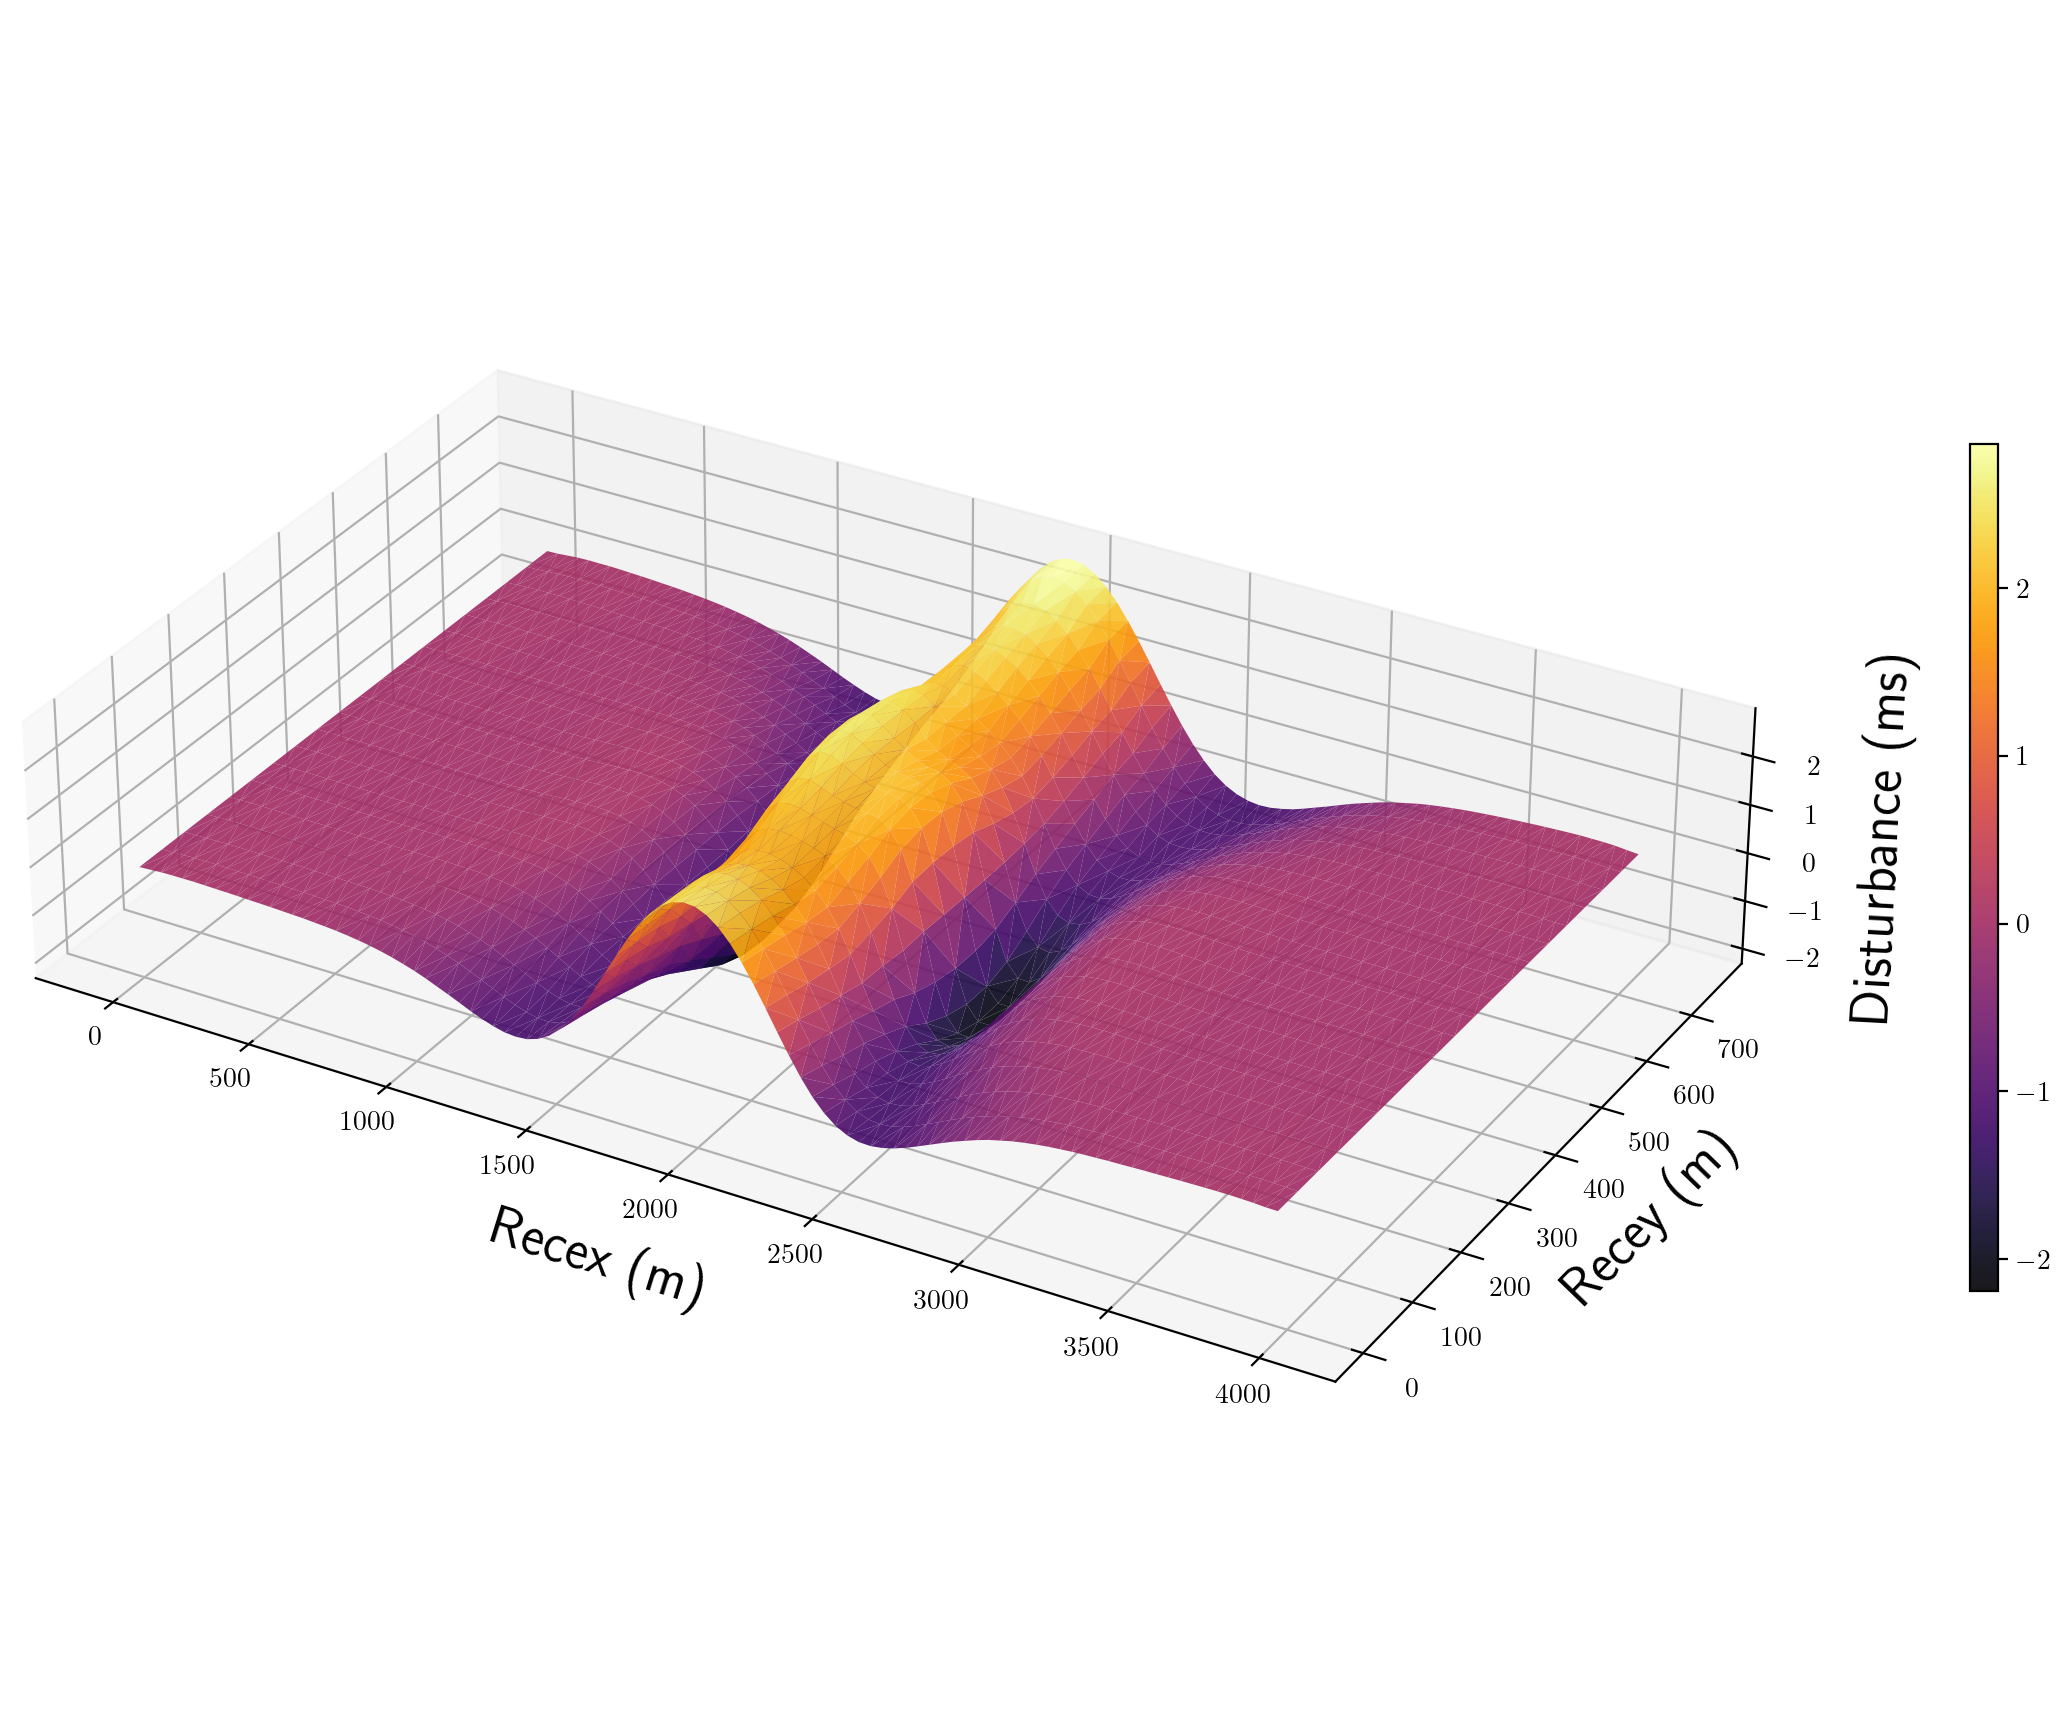

In [108]:
#绘制接收点扰动三维图
%config InlineBackend.figure_format = 'retina'
G1st = pd.read_csv('path/to/G1st.csv')
G2nd = pd.read_csv('path/to/G2nd.csv')
G3rd = pd.read_csv('path/to/G3rd.csv')
G_shot_num_flat = G1st['G1st'] + G2nd['G2nd'] + G3rd['G3rd']
plt.rcParams.update({'text.usetex': True})
fig = plt.figure(figsize=(33, 11))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Rece_x, Rece_y, G_shot_num_flat , cmap='inferno', linewidth=0.2, alpha=0.9)
cbar = fig.colorbar(surf, shrink=0.5, aspect=30) 

ax.set_xlabel(r'Recex (m)', fontsize=14,labelpad=20)
ax.set_ylabel(r'Recey (m)', fontsize=14)
ax.set_zlabel(r'Disturbance (ms)', fontsize=14)

ax.set_box_aspect([5,3,1])

# plt.title('Disturbance of Receiver',fontsize = 20)
plt.show()

In [109]:
pd.DataFrame({'G': G_shot_num_flat * (4 / 3)}).to_csv('/Users/bracopitzy/Desktop/四川大学/2023大三上/Numerical Analysis/BigAssigment/GGG.csv', index=False)

In [110]:
pd.DataFrame({'Recenum':df['ReceNum'].unique()}).to_csv('/Users/bracopitzy/Desktop/四川大学/2023大三上/Numerical Analysis/BigAssigment/Recenum.csv', index=False)

In [7]:
#绘制接收点扰动三维图
import pandas as pd
import numpy as np
import sympy as sp
import sympy
import matplotlib.pyplot as plt

df = pd.read_csv('path/to/ShotReceData.csv')
#得到每各接收点的坐标
Rece_x = np.concatenate(df.groupby('ReceNum')['Recex'].unique().reset_index()['Recex'])
Rece_y = np.concatenate(df.groupby('ReceNum')['Recey'].unique().reset_index()['Recey'])

#得到每各炮点的坐标
Shot_x = np.concatenate(df.groupby('ShotNum')['Shotx'].unique().reset_index()['Shotx'])
Shot_y = np.concatenate(df.groupby('ShotNum')['Shoty'].unique().reset_index()['Shoty'])
%config InlineBackend.figure_format = 'retina'
G1st = pd.read_csv('path/to/G1st.csv')
G2nd = pd.read_csv('path/to/G2nd.csv')
G3rd = pd.read_csv('path/to/G3rd.csv')
G_shot_num_flat =G2nd['G2nd'] + G3rd['G3rd']
plt.rcParams.update({'text.usetex': True})
fig = plt.figure(figsize=(33, 11))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Rece_x, Rece_y, G_shot_num_flat *5, cmap='hot', linewidth=0.2, alpha=0.9)
cbar = fig.colorbar(surf, shrink=0.5, aspect=30) 

ax.set_xlabel(r'Recex (m)', fontsize=14)
ax.set_ylabel(r'Recey (m)', fontsize=14)
ax.set_zlabel(r'Disturbance (ms)', fontsize=14)


# plt.title('Disturbance of Receiver',fontsize = 20)
plt.show()

In [10]:
#绘制炮点扰动三维图
Deltadf = pd.read_csv('path/to/Delta200.csv')
Delta200 = Deltadf['Delta']
plt.rcParams.update({'text.usetex': True})
fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Shot_x, Shot_y, Delta200 * 10 ** (-3) , cmap='hot', linewidth=0.2, alpha=0.9)
cbar = fig.colorbar(surf, shrink=0.5, aspect=30) 

ax.set_xlabel(r'Recex (m)', fontsize=14)
ax.set_ylabel(r'Recey (m)', fontsize=14)
ax.set_zlabel(r'Disturbance (ms)', fontsize=14)

# plt.title('Disturbance of Shot Point',fontsize = 20)
plt.show()